# Cell 1: Install dependencies

In [58]:

!pip install pyspark textblob requests


#  Cell 2: Imports

In [70]:
import requests
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, FloatType
from textblob import TextBlob
from typing import List, Dict
import pandas as pd
import matplotlib.pyplot as plt


#  Cell 3: Initialize Spark Session

In [60]:
spark = (
    SparkSession.builder
    .appName("GNewsSentimentAnalysis")
    .master("local[*]")
    .getOrCreate()
)


#  Cell 4: API Key Setup


In [61]:

GNEWS_API_KEY = "1809f6601f4466e725584914ad8dec61"



In [62]:

def fetch_gnews(api_key: str, query: str = "finance", lang: str = "en") -> List[Dict]:
    url = f"https://gnews.io/api/v4/search?q={query}&lang={lang}&token={api_key}"

    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()

        articles = data.get("articles", [])
        formatted = [
            {
                "title": art.get("title"),
                "description": art.get("description"),
                "url": art.get("url"),
                "source": art.get("source", {}).get("name"),
            }
            for art in articles if art.get("title")
        ]
        return formatted

    except requests.exceptions.RequestException as e:
        print(f" Error fetching news: {e}")
        return []


#  Cell 6: Sentiment Functions

In [66]:

def get_sentiment_score(title: str, description: str = "") -> float:
    text = f"{title} {description}".strip()
    if not text:
        return 0.0
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

def get_sentiment_label(score: float) -> str:
    if score > 0.1:
        return "Positive"
    elif score < 0.0:
        return "Negative"
    return "Neutral"


# Cell 7: PySpark Sentiment Analysis

In [67]:

def analyze_sentiment(articles: List[Dict]) -> List[Dict]:
    if not articles:
        return []

    df = spark.createDataFrame(articles)


    def udf_score(title, description):
        return get_sentiment_score(title, description)

    score_udf = udf(udf_score, FloatType())
    label_udf = udf(get_sentiment_label, StringType())

    enriched_df = (
        df.withColumn("sentiment_score", score_udf(df["title"], df["description"]))
          .withColumn("sentiment_label", label_udf(score_udf(df["title"], df["description"])))
    )

    return [row.asDict() for row in enriched_df.collect()]


#  Cell 8: Run Pipeline + Display Sorted Table + Visualization

🔎 Fetching latest finance news from GNews...
✅ Retrieved 10 articles.
📊 Sentiment analysis complete!



,title,source,sentiment_score,sentiment_label,url
0,XRP-Ripple Inspired MAGACOIN FINANCE Gains Market Traction Across Investor Notes,The Manila Times,0.312121,Positive,https://www.manilatimes.net/2025/09/28/tmt-newswire/globenewswire/xrp-ripple-inspired-magacoin-finance-gains-market-traction-across-investor-notes/2191525
1,FM Nirmala Sitharaman to inaugurate Kautilya Economic Conclave on October 3,The Economic Times,0.100000,Positive,https://economictimes.indiatimes.com/news/economy/policy/fm-nirmala-sitharaman-to-inaugurate-kautilya-economic-conclave-on-october-3/articleshow/124185426.cms
2,Bail granted to accused in luxury car crash case,The Hindu,0.000000,Neutral,https://www.thehindu.com/news/cities/Delhi/bail-granted-to-accused-in-luxury-car-crash-case/article70103136.ece
3,Ripple Partners with Ondo Finance to Tokenize U.S. Treasuries,CoinGape,0.000000,Neutral,https://coingape.com/ripple-partners-with-ondo-finance-to-tokenize-u-s-treasuries/
4,UBS Remains a Hold on Bajaj Housing Finance Ltd. (BAJAJHFL),Markets Insider,0.000000,Neutral,https://markets.businessinsider.com/news/stocks/ubs-remains-a-hold-on-bajaj-housing-finance-ltd-bajajhfl-1035220464
5,UBS Reaffirms Their Buy Rating on Cholamandalam Investment and Finance Co. Ltd. (CHOLAFIN),Markets Insider,0.000000,Neutral,https://markets.businessinsider.com/news/stocks/ubs-reaffirms-their-buy-rating-on-cholamandalam-investment-and-finance-co-ltd-cholafin-1035220467
6,Shriram Finance Limited (SHRIRAMFIN) Receives a Buy from UBS,Markets Insider,-0.071429,Negative,https://markets.businessinsider.com/news/stocks/shriram-finance-limited-shriramfin-receives-a-buy-from-ubs-1035220465
7,UBS Remains a Buy on PNB Housing Finance Limited (PNBHOUSING),Markets Insider,-0.071429,Negative,https://markets.businessinsider.com/news/stocks/ubs-remains-a-buy-on-pnb-housing-finance-limited-pnbhousing-1035220466
8,UBS Sticks to Its Buy Rating for Power Finance Corporation Limited (PFC),Markets Insider,-0.071429,Negative,https://markets.businessinsider.com/news/stocks/ubs-sticks-to-its-buy-rating-for-power-finance-corporation-limited-pfc-1035220469
9,Bajaj Finance Limited (BAJFINANCE) Gets a Sell from UBS,Markets Insider,-0.071429,Negative,https://markets.businessinsider.com/news/stocks/bajaj-finance-limited-bajfinance-gets-a-sell-from-ubs-1035220471


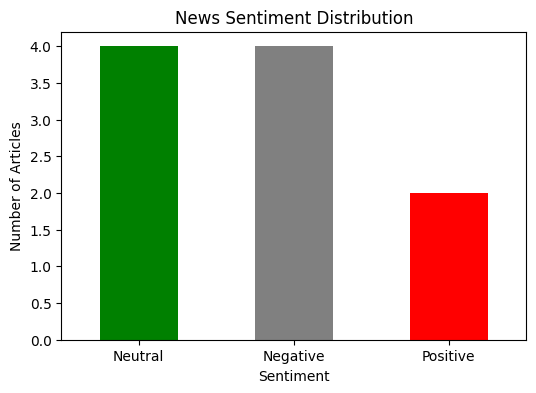

In [71]:

print("🔎 Fetching latest finance news from GNews...")

news_data = fetch_gnews(GNEWS_API_KEY, query="finance")

if news_data:
    print(f"✅ Retrieved {len(news_data)} articles.")

    results = analyze_sentiment(news_data)
    print("📊 Sentiment analysis complete!\n")


    df_results = pd.DataFrame(results, columns=["title", "source", "sentiment_score", "sentiment_label", "url"])


    df_sorted = df_results.sort_values(by="sentiment_score", ascending=False).reset_index(drop=True)


    display(df_sorted.head(15))


    sentiment_counts = df_sorted["sentiment_label"].value_counts()

    plt.figure(figsize=(6,4))
    sentiment_counts.plot(kind="bar", color=["green", "gray", "red"])
    plt.title("News Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Number of Articles")
    plt.xticks(rotation=0)
    plt.show()
else:
    print("⚠️ No articles found.")
